<a href="https://colab.research.google.com/github/mansiraturi/tnbc_Detection/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

import sklearn.linear_model as skl_lm
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.model_selection import train_test_split

import pickle

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing

**Load & Handle Gene Features**

In [ ]:
clinical= pd.read_csv('/content/drive/MyDrive/TNBC/brca_tcga_clinical_data.tsv', delimiter="\t")

In [ ]:
genes = genes = pd.read_csv('/content/drive/MyDrive/TNBC/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt', delimiter="\t")

In [ ]:
genes.shape

(20531, 1102)

In [ ]:
genes.head()

,Hugo_Symbol,Entrez_Gene_Id,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5L-AAT1-01,TCGA-5T-A9QA-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
0,LOC100130426,100130426,-1.7608,-1.7608,1.1240,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,...,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608
1,UBE2Q2P3,100133144,1.0944,0.3540,0.6451,0.6963,-0.0246,-0.6627,-2.9270,-1.6563,...,-2.4538,-0.5741,-2.9270,-0.2765,-2.9270,-2.9270,0.9240,1.5101,-1.2605,-0.0175
2,UBE2Q2P3,100134869,1.0230,1.4736,0.5206,0.7910,1.1891,1.1002,0.7244,0.4830,...,1.1830,0.7643,-0.9748,1.1829,-0.0262,-0.9051,1.7984,2.1743,0.1793,2.0240
3,HMGB1P1,10357,-1.7033,-1.0056,0.9114,0.7418,-0.5522,0.1842,0.2208,0.0383,...,0.5990,0.6079,-3.0182,0.4649,-1.6364,-2.2051,0.6371,-1.2071,-0.5285,1.1111
4,TIMM23,10431,-2.5248,-1.6307,0.8069,-0.4455,-0.7821,-0.6367,0.2389,0.9257,...,1.2029,2.8887,1.4583,-1.0420,0.5612,1.6977,-1.2260,-0.9444,0.3174,-0.0360


In [ ]:
## Set aside gene name to numerical id
## Will be exported for reuse
gene_map = genes.iloc[:, 0:2]

**Drop ESR1 (estrogen receptor), PGR (progesterone receptor), ERBB2 (HER2 receptor) genes to prevent data leakage**

In [ ]:
## First check if the 3 genes are in the data
GENES_TO_DROP = ["ESR1", "PGR", "ERBB2"]
[g in genes["Hugo_Symbol"].values for g in GENES_TO_DROP]

[True, True, True]

In [ ]:
## Next, drop the 3 genes from the dataframe
genes = genes.loc[~genes["Hugo_Symbol"].isin(GENES_TO_DROP), :]

In [ ]:
## Check: all should be False
[g in genes["Hugo_Symbol"].values for g in GENES_TO_DROP]

[False, False, False]

In [ ]:
# assert not any(genes.duplicated("Entrez_Gene_Id"))  #ensure no duplicate id
genes.index = genes["Entrez_Gene_Id"]
genes = genes.iloc[:, 2:] #drop gene id cols

In [ ]:
## Transpose dataframe such that each row=patient(observation), each col=gene(feature)
genes = genes.transpose()
genes.head() #preview again

Entrez_Gene_Id,100130426,100133144,100134869,10357,10431,136542,155060,26823,280660,317712,...,7789,158586,79364,440590,79699,7791,23140,26009,387590,389932
TCGA-3C-AAAU-01,-1.7608,1.0944,1.0230,-1.7033,-2.5248,NaN,2.6672,-1.9754,-1.0239,-3.8503,...,1.6674,1.3652,1.7323,1.1787,1.0112,0.0077,1.2480,0.7011,-2.2857,-1.0151
TCGA-3C-AALI-01,-1.7608,0.3540,1.4736,-1.0056,-1.6307,NaN,1.4841,0.6553,-0.5570,-3.8503,...,0.0469,-0.2845,0.8841,0.9389,-0.8990,0.9335,0.3568,-1.8110,1.7416,-1.0151
TCGA-3C-AALJ-01,1.1240,0.6451,0.5206,0.9114,0.8069,NaN,1.6791,-1.9754,-1.0239,-3.8503,...,-1.0439,0.0704,-1.3588,1.4057,-1.2453,0.9163,-0.4675,-1.2802,-0.4957,-1.0151
TCGA-3C-AALK-01,-1.7608,0.6963,0.7910,0.7418,-0.4455,NaN,1.5817,-0.7379,-1.0239,-3.8503,...,-0.1270,-0.3346,-0.8902,0.8269,-0.8818,1.0020,-0.9299,-0.5286,-0.0672,-1.0151
TCGA-4H-AAAK-01,-1.7608,-0.0246,1.1891,-0.5522,-0.7821,NaN,0.5166,-0.7082,-1.0239,-3.8503,...,-0.3710,-0.3982,-0.1067,-1.4182,-0.2086,0.2990,-0.7752,0.0127,0.6400,-1.0151


In [ ]:
COLUMNS_CLIN = [
    'Sample ID', #ids
    'Sample Type','Fraction Genome Altered', #tumor info
    'Diagnosis Age','Sex','Race Category','Ethnicity Category', #patient info
    'Informed consent verified', #ethics
    'ER Status By IHC','PR status by ihc','IHC-HER2' #required for CLASS LABEL
]

clinical = clinical[COLUMNS_CLIN]
clinical.head()

,Sample ID,Sample Type,Fraction Genome Altered,Diagnosis Age,Sex,Race Category,Ethnicity Category,Informed consent verified,ER Status By IHC,PR status by ihc,IHC-HER2
0,TCGA-3C-AAAU-01,Primary,0.7787,55.0,Female,WHITE,NOT HISPANIC OR LATINO,YES,Positive,Positive,Negative
1,TCGA-3C-AALI-01,Primary,0.7164,50.0,Female,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,YES,Positive,Positive,Positive
2,TCGA-3C-AALJ-01,Primary,0.5340,62.0,Female,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,YES,Positive,Positive,Indeterminate
3,TCGA-3C-AALK-01,Primary,0.0764,52.0,Female,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,YES,Positive,Positive,Positive
4,TCGA-4H-AAAK-01,Primary,0.2364,50.0,Female,WHITE,NOT HISPANIC OR LATINO,YES,Positive,Positive,Equivocal


**Subset data & re-group features**

In [ ]:
clinical = clinical[(clinical["Sex"]=="Female") & (clinical["Sample Type"]=="Primary")]

In [ ]:
print("Number of NaNs: %d" % sum(clinical['Race Category'].isna()))
clinical['RaceWhite'] = (clinical['Race Category']=="WHITE")

Number of NaNs: 94


**Define class labels, 1 if a cancer is ER-negative, PR-negative, and HER2-negative; 0 otherwise**

In [ ]:
clinical.loc[clinical['Race Category'].isna(), "RaceWhite"] = None
sum(clinical['RaceWhite'].isna()) #should be same as above

94

In [ ]:
## The last 3 integers indicate missing receptors required to define labels
[sum(clinical[col].isna()) for col in COLUMNS_CLIN]

[0, 0, 18, 1, 0, 94, 171, 0, 49, 50, 176]

In [ ]:
## Initialize the label definition:
clinical['Label'] = (clinical['ER Status By IHC']=='Negative') & \
                    (clinical['PR status by ihc']=='Negative') & \
                    (clinical['IHC-HER2']=='Negative')

In [ ]:
clinical.loc[:,['ER Status By IHC','PR status by ihc','IHC-HER2']].isna()

,ER Status By IHC,PR status by ihc,IHC-HER2
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
1103,False,False,False
1104,False,False,False
1105,False,False,False
1106,False,False,False


In [ ]:
## Count the number of missing receptors in each patient or sample
clinical['num_receptor_missing'] = clinical.loc[:,['ER Status By IHC','PR status by ihc','IHC-HER2']].isna().sum(axis=1)
set(clinical['num_receptor_missing'].to_list()) #few as 0, up to all 3 missing

{0, 1, 2, 3}

In [ ]:
## Begin by setting any patient with 1+ receptor missing has having Label=None
clinical.loc[clinical['num_receptor_missing']>0, "Label"] = None
sum(clinical['Label'].isna())

178

In [ ]:
## Then, re-set Label=0 from NaN if at least 1 receptor is NOT negative
label0_indicator = ['Positive','Intermediate','Equivocal']

clinical.loc[clinical['ER Status By IHC'].isin(label0_indicator) | \
         clinical['PR status by ihc'].isin(label0_indicator) | \
         clinical['IHC-HER2'].isin(label0_indicator), "Label"] = 0

sum(clinical['Label'].isna())

83

In [ ]:
## Finally, exclude label-less rows (patients)
clinical = clinical.loc[~clinical['Label'].isna(), :]

In [ ]:
!pip install tableone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tableone import TableOne

selected_cols = ['Sex','RaceWhite','num_receptor_missing','Informed consent verified']

myTable1 = TableOne(
    clinical,
    columns = selected_cols,
    groupby = 'Label'
)

In [ ]:
## Column 'True' or '1.0' means Class=1, i.e. the triple negative cancers
print(myTable1.tabulate(tablefmt="rst"))

================================  ======  =========  ============  ===========  ===========
..                                        Missing    Overall       0            True
================================  ======  =========  ============  ===========  ===========
n                                                    1002          886          116
Sex, n (%)                        Female  0          1002 (100.0)  886 (100.0)  116 (100.0)
RaceWhite, n (%)                  False   94         216 (23.8)    176 (22.0)   40 (36.7)
..                                True               692 (76.2)    623 (78.0)   69 (63.3)
num_receptor_missing, n (%)       0       0          907 (90.5)    791 (89.3)   116 (100.0)
..                                1                  95 (9.5)      95 (10.7)
Informed consent verified, n (%)  YES     0          1002 (100.0)  886 (100.0)  116 (100.0)
================================  ======  =========  ============  ===========  ===========


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
sum(clinical['Sample ID'].isin(genes.index))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


999

In [ ]:
sum(genes.index.isin(clinical['Sample ID'])) #should match cell above

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


999

In [ ]:
clinical = clinical.loc[clinical['Sample ID'].isin(genes.index), :]
clinical.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(999, 14)

In [ ]:
genes = genes.loc[clinical['Sample ID'],:]
genes.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(999, 20528)

In [ ]:
## Bonus: Confirm mutually subsetted dataframes are also matched
all(genes.index == clinical['Sample ID'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True

In [ ]:
clinical.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(999, 14)

In [ ]:
genesWithNan = genes.columns[genes.isna().any()].tolist()
len(genesWithNan)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


319

In [ ]:
gene = genes.dropna(axis=1)
gene.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(999, 20209)

#Explore Data via Unsupervised Learning

In [ ]:
def plot_dimred(X_r, y, title, labels=[0,1],
                target_names=["Other","Triple Neg."], colors=['navy','darkorange']):
    """ Plots dimensionality reduced data """
    plt.figure(dpi=100)

    for color, label, target_name in zip(colors, labels, target_names):
        plt.scatter(
            X_r[y == label, 0],
            X_r[y == label, 1],
            color=color,
            label=target_name
        )

    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")

    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(gene)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PCA(n_components=2)

In [ ]:
X_pca = pca.transform(gene)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


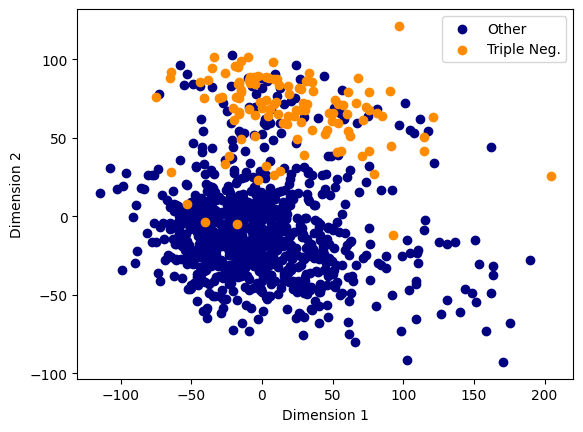

In [ ]:
plot_dimred(X_pca, clinical["Label"].values ,"PCA")

#Feature Selection for Supervised Learning

In [ ]:
# Check to see if patient IDs in the 2 DataFrames match
all(genes.index == clinical['Sample ID'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True

**Exclude genes with missing values**

In [ ]:
genesWithNan = genes.columns[genes.isna().any()].tolist()
len(genesWithNan) / genes.shape[1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.01553975058456742

In [ ]:
genes = genes.dropna(axis=1)
genes.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(999, 20209)

**L1-based Feature Selection**

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
clinical.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(999, 14)

In [ ]:
lsvc.fit(genes, clinical["Label"].astype(int).values)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LinearSVC(C=0.01, dual=False, penalty='l1')

In [ ]:
model = SelectFromModel(lsvc, prefit=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
genes_l1 = model.transform(genes)
genes_l1.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(999, 53)

In [ ]:
## Set aside gene features selected
selected_features = genes.columns[model.get_support()]
selected_features #entrez gene Ids

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Int64Index([155465,  91074,    696, 143379,  57150, 401546, 401535,    786,
             54901, 729767,   1131,   9071, 202333,  22866,  27254,   1452,
              1602,   2303,   2300, 161835,   2625,   9118,  10265,   3787,
            126823,  55915, 285033, 164312, 116372, 284348,   9313, 193629,
            145957, 169611,  93210,  94026,   5460,  25837, 255426, 140032,
              6500,  26781,   6627, 254122,   7031,   3195,   7104,  11013,
              9654,   7368, 131669, 646799,   7748],
           dtype='int64', name='Entrez_Gene_Id')

In [ ]:
len(selected_features) #should match genes_l1.shape[1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


53

In [ ]:
genes_l1 = pd.DataFrame(genes_l1)
genes_l1.columns = selected_features #selected features
genes_l1.index = genes.index #observations
genes_l1.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Entrez_Gene_Id,155465,91074,696,143379,57150,401546,401535,786,54901,729767,...,254122,7031,3195,7104,11013,9654,7368,131669,646799,7748
TCGA-3C-AAAU-01,0.7440,0.8410,-0.5802,-1.3485,-0.6921,0.6167,-1.3062,-1.1856,-0.4918,-728.237,...,-0.8150,-0.6914,0.7391,-0.5315,0.6873,-0.8691,-1.7097,2.0565,-0.5525,0.7877
TCGA-3C-AALI-01,0.8540,0.3367,-0.3288,1.1354,-1.0560,0.4525,-0.7934,1.2827,0.1886,-728.237,...,-0.3699,-0.3852,-1.1189,-0.6382,0.3087,-0.8485,-0.8453,1.0001,-0.1701,-0.7506
TCGA-3C-AALJ-01,0.5845,1.1259,-0.4364,-1.6026,-2.3766,-3.4345,-1.3062,0.1288,-0.2670,-728.237,...,-0.6935,-0.3153,-1.1189,-1.1524,1.0042,-0.7447,-1.0931,-0.1528,-1.3726,1.3994
TCGA-3C-AALK-01,0.1980,0.8446,-0.2444,0.3630,0.1833,0.8912,-0.1531,0.5450,-0.2639,-728.237,...,-0.3610,1.1335,-1.1189,0.3251,0.0023,-0.1078,-0.0454,-0.2259,-0.4139,-0.0499
TCGA-4H-AAAK-01,0.2268,0.4394,-0.7818,0.6868,0.1617,0.6758,-0.1323,0.4103,-0.1716,-728.237,...,0.8746,0.8219,-1.1189,-0.7326,0.5726,-0.4827,-0.0001,-1.2664,-0.3909,0.1956


In [ ]:
clinical.index = clinical['Sample ID'].values
clinical.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(999, 14)

In [ ]:
## Check to see if patient IDs in the 2 DataFrames match
assert all(genes.index == clinical.index)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
y = clinical["Label"].astype(int)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Supervised Learning with SVM with Hyperparameter Tuning as Benchmark

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(genes, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class_weights = len(y) / (2 * np.bincount(y))
class_weights #balanced class weights

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.56504525, 4.34347826])

In [ ]:
## Relative positive class weight
class_weights[1] / class_weights[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


7.6869565217391305

In [ ]:
sum(y == 0) / sum(y == 1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


7.6869565217391305

**Train SVM with Hyperparameter Tuning**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from scipy import stats

NUM_CANDIDATES = 20
SVM_PARAMS = {'C': stats.expon(scale=100), 'gamma': stats.expon(scale=0.1)}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
idx_validation = np.random.choice(range(Xtrain.shape[0]), size=200)
idx_train = np.setdiff1d(range(Xtrain.shape[0]), idx_validation)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
random_search = RandomizedSearchCV(
    SVC(max_iter = 20, kernel="rbf", class_weight='balanced'),
    param_distributions = SVM_PARAMS,
    n_iter = NUM_CANDIDATES,
    cv = [(idx_train, idx_validation)], #hold out validation
    scoring = "roc_auc"
)

random_search.fit(Xtrain, ytrain)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RandomizedSearchCV(cv=[(array([  0,   1,   4,   7,  11,  12,  17,  18,  19,  20,  21,  22,  23,
        25,  26,  27,  28,  29,  30,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  43,  44,  45,  46,  47,  48,  50,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  65,  67,  68,  69,  71,
        74,  76,  77,  78,  79,  80,  81,  82,  83,  84,  86,  87,  88,
        89,  90,  91,  92,  94,  95,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 108, 111, 112, 113, 114, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 128, 129, 1...
       323, 204, 303, 786, 751, 481, 597,   3,   9, 435, 587, 515, 560,
       446, 157, 706,  85, 429,  73, 448, 231, 604, 671, 794, 599, 177,
       754, 785, 329, 115, 778]))],
                   estimator=SVC(class_weight='balanced', max_iter=20),
                   n_iter=20,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f74e1052620>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f74e10526e0>},
                   scoring='roc_auc')

In [ ]:
df_tune = pd.DataFrame({
    "Hyperparam C": random_search.cv_results_["param_C"],
    "Hyperparam gamma": random_search.cv_results_["param_gamma"],
    "mean_AUC_score": random_search.cv_results_['mean_test_score']
})

df_tune.sort_values(by="mean_AUC_score", ascending=False, inplace=True)
df_tune

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Hyperparam C,Hyperparam gamma,mean_AUC_score
0,66.915127,0.008991,0.957611
9,160.722094,0.019637,0.955470
7,14.7052,0.019346,0.955470
12,107.105454,0.020949,0.954399
16,133.491029,0.023304,0.952259
4,253.033268,0.00296,0.951937
17,18.639485,0.026287,0.901413
5,354.265511,0.029829,0.848962
2,76.627994,0.031749,0.833654
19,298.358057,0.005682,0.661850


In [ ]:
random_search.best_score_ #double-check

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.9576107899807321

**Evaluation metrics on the Test Set**

In [ ]:
## Retrieve the best model:
svm = random_search.best_estimator_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
yTestScore = svm.predict(Xtest)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
yTestPred = svm.predict(Xtest)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(metrics.classification_report(ytest, yTestPred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       172
           1       0.60      0.86      0.71        28

    accuracy                           0.90       200
   macro avg       0.79      0.88      0.82       200
weighted avg       0.92      0.90      0.91       200



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# compute and print accuracy score

from sklearn.metrics import accuracy_score

print('SVM model accuracy score: {0:0.4f}'. format(accuracy_score(ytest, yTestPred)))

SVM model accuracy score: 0.9000


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
## Confusion matrix
metrics.confusion_matrix(ytest, yTestPred)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[156,  16],
       [  4,  24]])

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pip install scikit-plot

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print(yTestScore)

[1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1
 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def plot_roc(ytrue, yscore):
    """ Wrapper to plot ROC curve for binary classification """
    from sklearn import metrics

    plt.figure(dpi=100)

    fpr, tpr, _ = metrics.roc_curve(ytrue, yscore)
    auc = metrics.roc_auc_score(ytrue, yscore)
    plt.plot(fpr,tpr,label="AUC=%.3f" % auc)
    plt.legend(loc=4)

    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


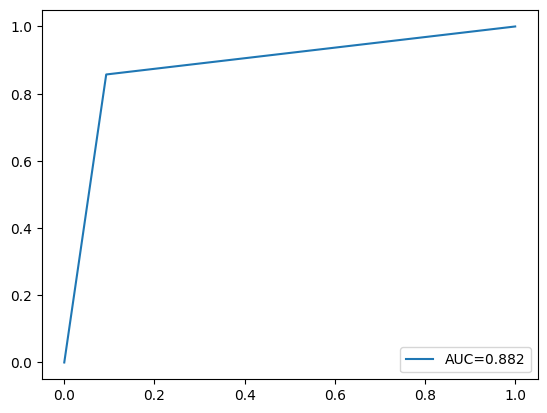

In [ ]:
plot_roc(ytest, yTestScore)

#Supervised Learning with XGBoost

In [ ]:
## Check to see if patient IDs in the 2 DataFrames match
assert all(genes.index == clinical.index)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
y = clinical["Label"].astype(int)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
genes = genes.loc[:,~genes.columns.duplicated()]

Xtrain, Xtest, ytrain, ytest = train_test_split(genes, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
## 2nd split to get validation set
# Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain.astype(int), test_size=0.2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
scale_pos_weight = sum(y == 0) / sum(y == 1)
print("Positive class weight = %.2f" % scale_pos_weight)

Positive class weight = 7.69


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class_weights = len(y) / (2 * np.bincount(y))
print("weight_0=%.2f, weight_1=%.2f" % tuple(class_weights))
print("sklearn version of class 1 weight %.2f" % (class_weights[1] / class_weights[0])) #should equal value in the cell above

weight_0=0.57, weight_1=4.34
sklearn version of class 1 weight 7.69


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# import machine learning libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
params = {
    'max_depth':range(0,20),
    'eta':np.arange(0.05,0.5),
    'gamma':np.arange(0,2),
    'min_child_weight':range(2,10),
    'subsample':np.arange(0.5,0.9),
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Run Hyperparameter Tuning via Random Search**

In [ ]:
#Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost
classifier = xgboost.XGBClassifier()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rs_model=RandomizedSearchCV(classifier, param_distributions=params,n_iter=5,scoring='roc_auc',verbose=3,error_score='raise')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#model fitting
rs_model.fit(Xtrain,ytrain)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END eta=0.05, gamma=0, max_depth=5, min_child_weight=6, subsample=0.5;, score=0.916 total time=  59.5s
[CV 2/5] END eta=0.05, gamma=0, max_depth=5, min_child_weight=6, subsample=0.5;, score=0.954 total time=  59.8s
[CV 3/5] END eta=0.05, gamma=0, max_depth=5, min_child_weight=6, subsample=0.5;, score=0.946 total time= 1.0min
[CV 4/5] END eta=0.05, gamma=0, max_depth=5, min_child_weight=6, subsample=0.5;, score=0.961 total time= 1.0min
[CV 5/5] END eta=0.05, gamma=0, max_depth=5, min_child_weight=6, subsample=0.5;, score=0.974 total time=  59.9s
[CV 1/5] END eta=0.05, gamma=0, max_depth=16, min_child_weight=7, subsample=0.5;, score=0.914 total time= 1.1min
[CV 2/5] END eta=0.05, gamma=0, max_depth=16, min_child_weight=7, subsample=0.5;, score=0.962 total time=  56.4s
[CV 3/5] END eta=0.05, gamma=0, max_depth=16, min_child_weight=7, subsample=0.5;, score=0.941 total time=  54.4s
[CV 4/5] END eta=0.05, gamma=0, max_depth

RandomizedSearchCV(error_score='raise',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=Non...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=5,
                   param_distributions={'eta': array([0.05]),
                                        'gamma': array([0, 1]),
                                        'max_depth': range(0, 20),
                                        'min_child_weight': range(2, 10),
                                        'subsample': array([0.5])},
                   scoring='roc_auc', verbose=3)

In [ ]:
#parameters selected
rs_model.best_estimator_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.05, eval_metric=None,
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=16,
              max_leaves=None, min_child_weight=7, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
rs_model.best_score_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.9508199385995575

In [ ]:
#Building final classifier model
classifier=xgboost.XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.05, eval_metric=None,
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=16,
              max_leaves=None, min_child_weight=7,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# from sklearn.model_selection import cross_val_score
# score=cross_val_score(classifier,Xval,yval)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# print(score)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
classifier.fit(Xtrain,ytrain)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.05, eval_metric=None,
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=16,
              max_leaves=None, min_child_weight=7, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
yTestPred = classifier.predict(Xtest)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Evaluation metrics on the Test Set**

In [ ]:
# compute and print accuracy score
from sklearn.metrics import accuracy_score
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(ytest, yTestPred)))

XGBoost model accuracy score: 0.9250


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn import metrics

## Table of classification metrics
print(metrics.classification_report(ytest, yTestPred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       172
           1       0.74      0.71      0.73        28

    accuracy                           0.93       200
   macro avg       0.85      0.84      0.84       200
weighted avg       0.92      0.93      0.92       200



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(yTestPred)

[1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1
 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


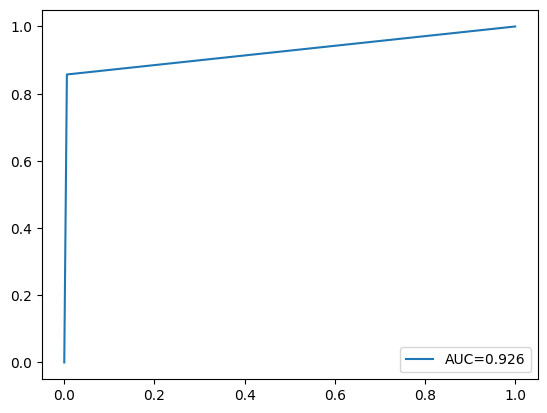

In [ ]:
plot_roc(ytest, yTestPred)